<font size="+3"><strong>Linear Regression Model</strong></font>

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import pytz
from pymongo import MongoClient
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# Prepare Data

## Import

In [ ]:
# Connect to the `MongoDB` server
client = MongoClient(host="localhost", port= 27017)
db = client["Air-Quality"]
dar = db["dar-es-salaam"]

In [ ]:
def wrangle(collection):
     # Bring the data from the database are read into the DataFrame `df`
     results = collection.find(
         {"metadata.site": 11, "metadata.measurement": "P2"},
         projection={"P2": 1, "timestamp": 1, "_id": 0},
         )
     # The index of df is the `timestamp` from the results
     df = pd.DataFrame(results).set_index("timestamp")

     return df

In [ ]:
df= wrangle(dar)
df.head()

,P2
timestamp,
2018-01-01 00:05:03.874,9.70
2018-01-01 02:09:53.933,8.97
2018-01-01 01:12:29.094,9.37
2018-01-01 02:29:51.379,9.50
2018-01-01 02:57:24.358,7.87


In [ ]:
# Modify the `DatetimeIndex` for `df` to the correct timezone "Asia/Shanghai".
df.index = df.index.tz_localize("UTC").tz_convert("Africa/Dar_es_Salaam")
df.head()

,P2
timestamp,
2018-01-01 03:05:03.874000+03:00,9.70
2018-01-01 05:09:53.933000+03:00,8.97
2018-01-01 04:12:29.094000+03:00,9.37
2018-01-01 05:29:51.379000+03:00,9.50
2018-01-01 05:57:24.358000+03:00,7.87


## 1.2 Explore

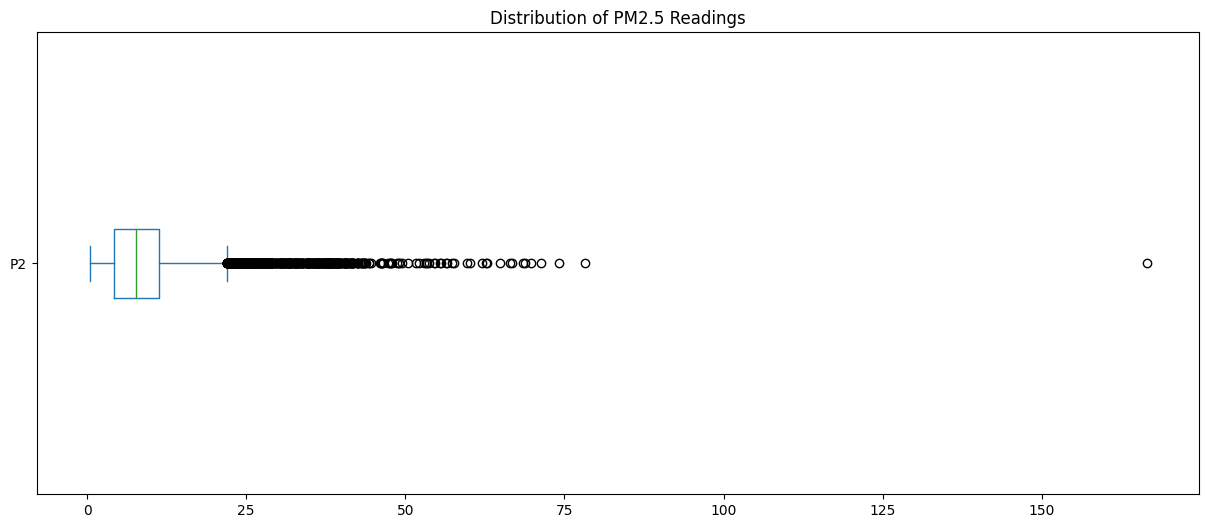

In [ ]:
# Distribution of the "PM2" readings in df.
fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].plot(kind="box", vert=False, title="Distribution of PM2.5 Readings",ax=ax);

In [ ]:
# Drop the outliers
df= df[df["P2"]<100]

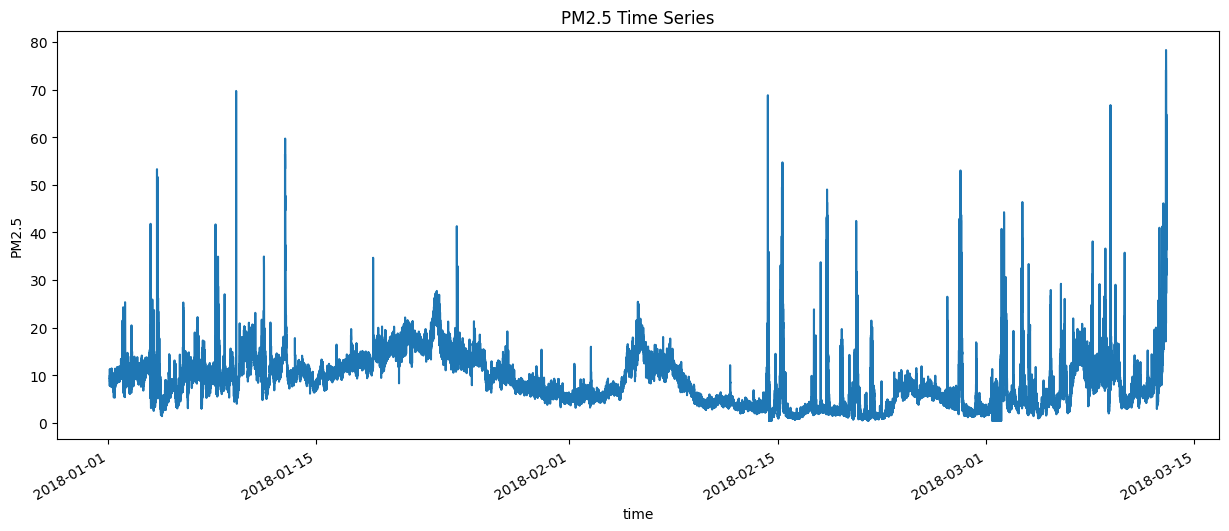

In [ ]:
# Time series plot of the `PM2` readings in `df`
fig, ax = plt.subplots(figsize=(15, 6))
df["P2"].plot(xlabel="time", ylabel="PM2.5", title="PM2.5 Time Series", ax=ax);

In [ ]:
# Resample df to provide the mean `PM2` reading for each hour
df= df["P2"]. resample("1H").mean().fillna(method="ffill").to_frame()

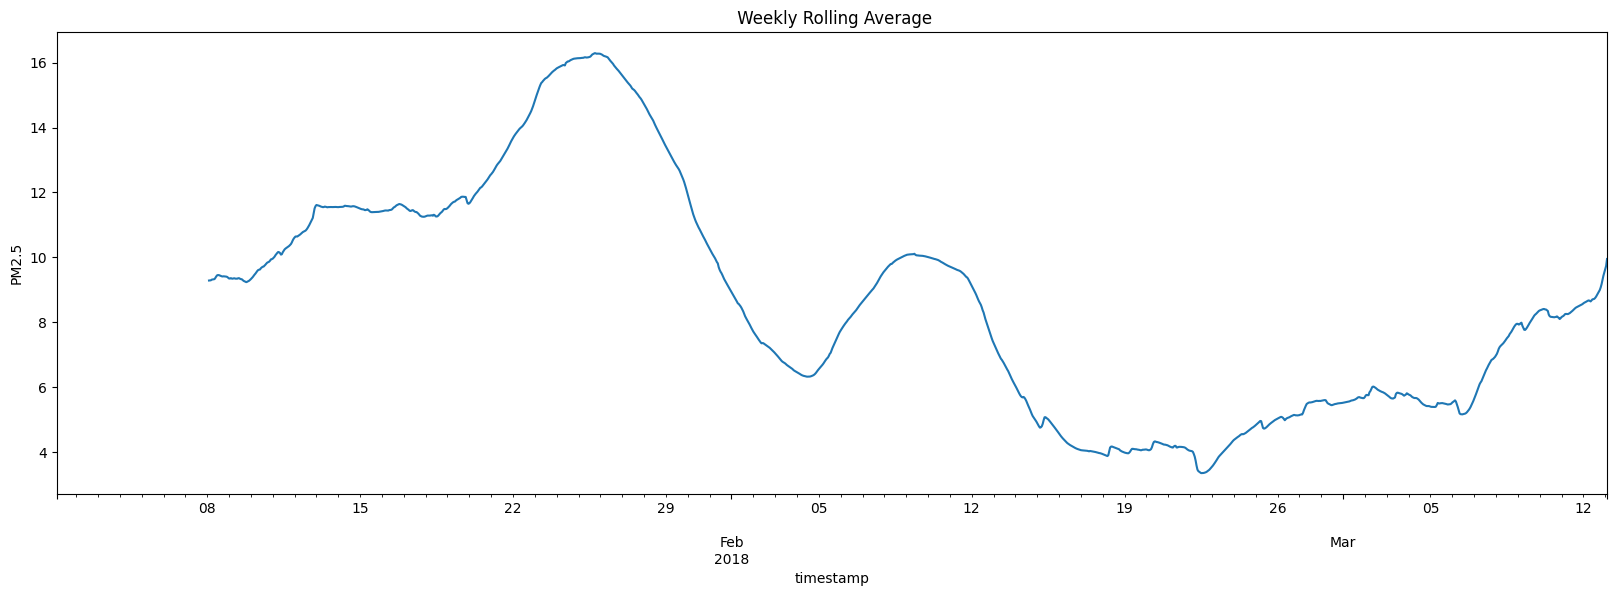

In [ ]:
# Rolling average of the `PM2` readings in `df`
# Window size of 168, the number of hours in a week
fig, ax = plt.subplots(figsize=(20, 6))
df["P2"].rolling(168).mean().plot(ax= ax, ylabel="PM2.5", title=" Weekly Rolling Average");

In [ ]:
# Create a column called `PM2.L1` that contains the mean "PM2" reading from the previous hou
df["P2.L1"] = df["P2"].shift(1)
df.dropna(inplace = True)

The final version of **wrangle** function

In [ ]:
def wrangle(collection):
     results = collection.find(
         {"metadata.station": "Aotizhongxin", "metadata.measurement": "PM2.5"},
         projection={"PM2": 1, "timestamp": 1, "_id": 0},
)

     df = pd.DataFrame(results).set_index(df["timestamp"])

     df.index=df.index.tz_localize("UTC").tz_convert("Asia/Shanghai")

     df = df[df["PM2"]<500]

     df = df["PM2"]. resample("1H").mean().fillna(method="ffill").to_frame()

     df["PM2.L1"] = df["PM2"].shift(1)

     df.dropna(inplace = True)

     return df

In [ ]:
# Correlation matrix
df.corr()

,P2,P2.L1
P2,1.000000,0.927715
P2.L1,0.927715,1.000000


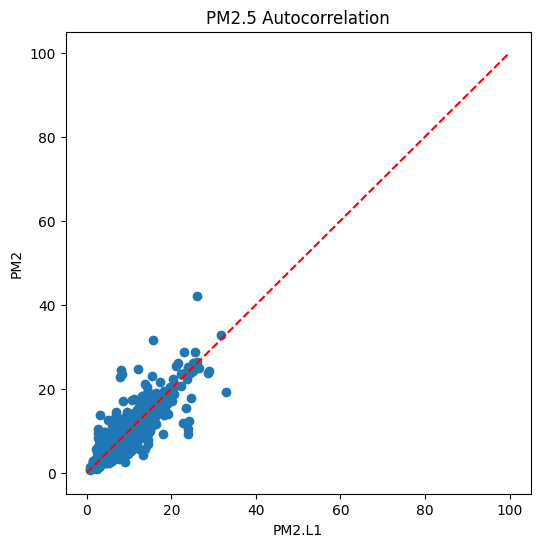

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x=df["P2.L1"], y=df["P2"])
ax.plot([0,100],[0,100],linestyle="--", color="red")
plt.xlabel("PM2.L1")
plt.ylabel("PM2")
plt.title("PM2.5 Autocorrelation");

## 1.3 Split

In [ ]:
# Split the DataFrame `df` into the feature matrix `X` and the target vector `y`
target = "P2"
y = df[target]
X = df.drop(columns= target)

In [ ]:
# Split `X` and `y` into training and test sets
cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

# 2. Build Model

## 2.1 Baseline

In [ ]:
# The baseline mean absolute error
y_pred_baseline = [y_train.mean()] * len(y_train)
mae_baseline = mean_absolute_error(y_train, y_pred_baseline)
print("Mean PM2 Reading:", round(y_train.mean(), 2))
print("Baseline MAE:", round(mae_baseline, 2))

Mean PM2 Reading: 9.01
Baseline MAE: 3.96


## 2.2 Iterate

In [ ]:
# Instantiate model
model = LinearRegression()
# Fit the model
model.fit(X_train, y_train)

LinearRegression()

## 2.3 Evaluate

I calculated the training and test mean absolute error for our model.

In [ ]:
# Training mean absolute error
training_mae = mean_absolute_error(y_train, model.predict(X_train))
# Test mean absolute error
test_mae = mean_absolute_error(y_test, model.predict(X_test))
print("Training MAE:", round(training_mae, 2))
print("Test MAE:", round(test_mae, 2))

Training MAE: 0.84
Test MAE: 1.46


# 3. Communicate Results

In [ ]:
# Extract the intercept and coefficient from our model
intercept = model.intercept_.round(2)
coefficient = model.coef_.round(2)[0]
print(f"PM2 = {intercept} + ({coefficient} * PM2.L1)")

PM2 = 0.5 + (0.94 * PM2.L1)


In [ ]:
# DataFrame `df_pred_test` contain the true values for our test set and our model’s predictions
df_pred_test = pd.DataFrame(
     {
          "y_test": y_test,
          "y_pred": model.predict(X_test)
     }
)
df_pred_test.head()

,y_test,y_pred
timestamp,,
2018-02-26 22:00:00+03:00,3.784167,4.141926
2018-02-26 23:00:00+03:00,4.715833,4.075355
2018-02-27 00:00:00+03:00,4.234444,4.954397
2018-02-27 01:00:00+03:00,3.892500,4.500199
2018-02-27 02:00:00+03:00,2.962778,4.177569


In [ ]:
fig = px.line(df_pred_test, labels= {"value": "P2"})
fig.show()